# Classifying skin lesions using a convolutional neural network

The goal of this assignment is to design and implement a deep learning model
able to determine the category of a skin lesion from a dermoscopic image.

This is a _multiclass classification_ problem where the inputs are RGB
images; therefore, the most natural approach is to use a Convolutional Neural
Network (CNN) for classification.

In this document I will go through the different steps of the data analysis
pipeline, explaining the reasons behind the choices I made and their
consequences on the results of the experiments.

#### Summary

This report is organized as follows:  

1. [**Data exploration**](#Data-exploration)
1. [**(brief) Literature review**](#Literature-review)
1. [**Experiment design**](#Experiment-design)
1. [**Implementation details**](#Implementation-details)
1. [**Results**](#Results)
1. [**Conclusions**](#Conclusions)

## Data exploration
[back to top](#Summary)

#### Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os
import sys

In [5]:
import numpy as np

In [6]:
import torchvision.transforms as transforms
import PIL

In [7]:
# Add parent folder to system path to allow loading modules
sys.path.append("..")

Set up folders

In [8]:
DATA_FOLDER = "../data"
ANNOTATION_FILE_NAME = "HAM10000_metadata.csv"
LABEL_COLUMN = 'dx'

### Read annotations

In [9]:
annotation_df = pd.read_csv(os.path.join(DATA_FOLDER, ANNOTATION_FILE_NAME))

In [10]:
annotation_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

## Data exploration
[back to top](#Summary)

The very first step in most data analysis pipelines consists in
_looking at the dataset_ and trying to understand its characteristics, in order
to make the appropriate decisions when designing the experiments.

The following table and plot show the number of samples present in the dataset for each
class.

In [11]:
# Use sample to get a bit more varied set of examples
annotation_df.sample(frac=1.0).head(n=15)

,lesion_id,image_id,dx,dx_type,age,sex,localization
6182,HAM_0004671,ISIC_0026013,nv,follow_up,50.0,female,upper extremity
3050,HAM_0005449,ISIC_0030102,nv,follow_up,55.0,male,trunk
6443,HAM_0004774,ISIC_0031497,nv,follow_up,30.0,female,trunk
6102,HAM_0001233,ISIC_0029110,nv,follow_up,35.0,male,upper extremity
4756,HAM_0001051,ISIC_0024686,nv,follow_up,35.0,male,back
9680,HAM_0001410,ISIC_0024830,nv,consensus,15.0,female,chest
467,HAM_0005935,ISIC_0026679,bkl,histo,70.0,female,chest
3120,HAM_0003671,ISIC_0029373,nv,follow_up,45.0,female,lower extremity
1296,HAM_0001913,ISIC_0030798,mel,histo,80.0,male,upper extremity
26,HAM_0002521,ISIC_0029291,bkl,histo,40.0,male,upper extremity


In [12]:
annotation_df.groupby(LABEL_COLUMN)['age'].describe()

,count,mean,std,min,25%,50%,75%,max
dx,,,,,,,,
akiec,327.0,66.529052,11.476232,30.0,60.0,70.0,75.0,85.0
bcc,514.0,66.828794,13.656959,20.0,60.0,70.0,75.0,85.0
bkl,1089.0,64.283747,14.120715,0.0,55.0,65.0,75.0,85.0
df,115.0,53.043478,13.551326,25.0,45.0,50.0,65.0,80.0
mel,1111.0,60.679568,15.189847,5.0,50.0,60.0,70.0,85.0
nv,6660.0,46.477477,15.183275,0.0,35.0,45.0,55.0,85.0
vasc,142.0,51.373239,21.644651,0.0,40.0,55.0,70.0,85.0


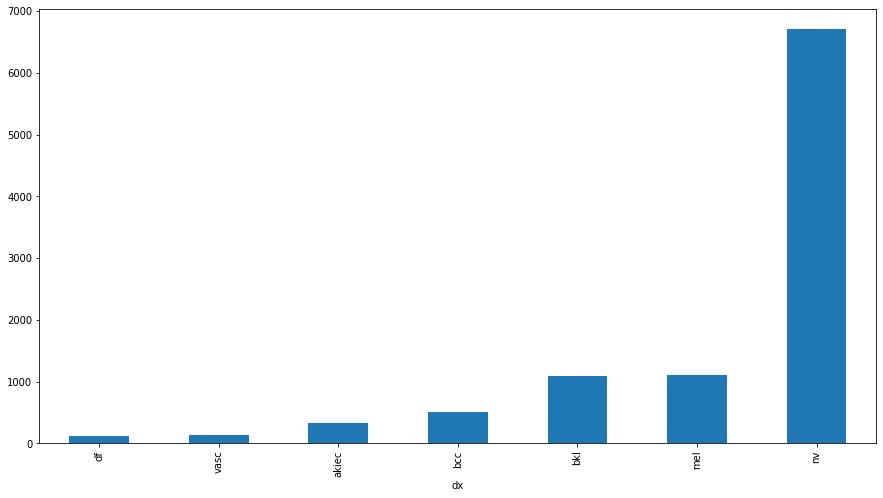

In [13]:
plt.figure(figsize=(15,8))
annotation_df.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar')

This plot clearly shows that the dataset is *heavily inbalanced*: the most
represented class is by far **nv**, corresponding to *benign melanocytic nevi*, with
6660 samples, while the least represented class, **df** (*dermatofibromas*), has
only 115 samples in this dataset.


This was to be expected, since medical datasets often contain many more samples
of a given feature (in this case, skin lesions) *not* affected by a disease than
samples presenting signs of a medical condition.


Apart from the evident class inbalance, some of the classes (most of them,
actually) have a very small number of samples in absolute terms, which may lead
to severe problems in the training process, unless properly addressed.


Finally, a consideration on the goal of the task itself: normally the
performance of a model trained to solve a classification task is evaluated based
on its *accuracy*, that is the percentage of samples from a *test set* (that is
a set which hasn't been used **in any way** during the training) which is
correctly classified by the model.
This is fine for most cases (and as a matter of fact it is one of the metrics
used in this analysis), however it is important to take into account the nature
of this problem, and in particular what the consequences of an error would be,
especially when commenting results.
The samples present in the set can be grouped in **two** categories: lesions
that are **malignant** (or eventually might develop into malignant ones), and
those which are **benign**. With that in mind, it is clear that
**type II errors** (false negatives, that is classifying a malignant lesion as a
benign one) should be minimized, at the cost of increasing the occurrence of
**type I errors** (false positives), since the consequences would be very different
for the two types of mistakes.

These are crucial aspects of this particular dataset, which will need to be
taken into consideration when choosing the parameters for the training process
(hyperparameters and overall training strategy). All of the choices made to
address the issues discussed above are explained in detail in section
[experiment design](#Experiment-design).

### Visualize sample images

Since the input are RGB images, visualizing a few of them for each class might
provide some useful insight.

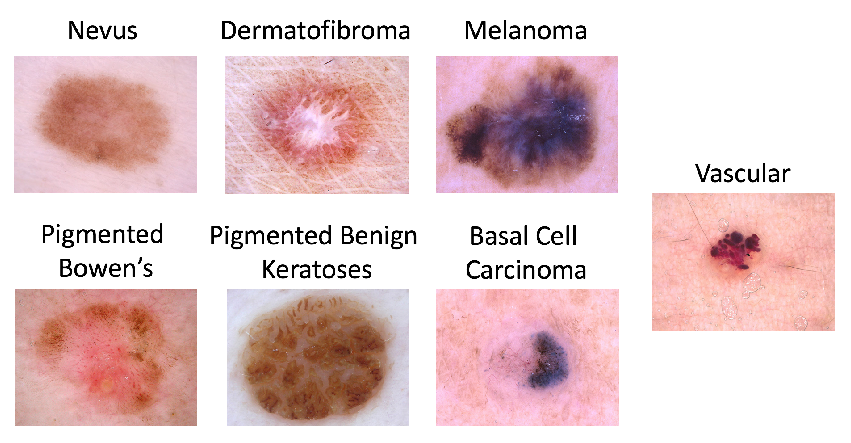

In [14]:
sample_image = plt.imread("../lesions.png")
plt.figure(figsize=(15,8))
plt.axis('off')
plt.imshow(sample_image);

Display a few images from the dataset on a grid in order to visually check their characteristics

In [15]:
from lib.dataset import HAM10000, create_train_val_split, read_meta_data

In [16]:
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2)

In [17]:
# Order so that classes that get confused are shown close to one another
class_labels = ['akiec', 'bkl', 'bcc', 'df', 'mel', 'nv', 'vasc']

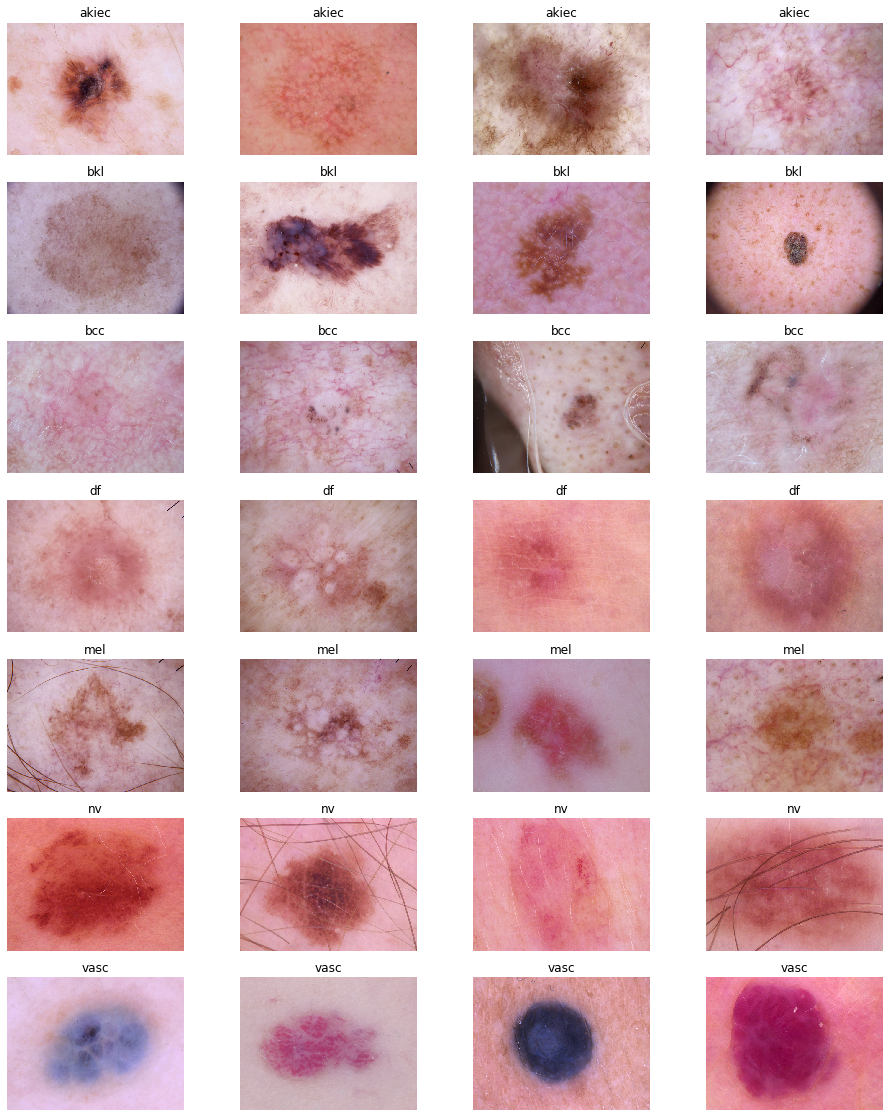

In [18]:
n_rows = len(class_labels)
n_cols = 4

f, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

for x, l in enumerate(class_labels):
    samples4 = annotation_df[(annotation_df['dx'] == l)].sample(frac=1.0, random_state=9876).iloc[:4]
    for y, im_id in enumerate(samples4['image_id']):
        img = plt.imread(os.path.join(DATA_FOLDER, "{}.jpg".format(im_id)))
        axes[x, y].axis('off')
        axes[x, y].imshow(img)
        axes[x, y].set_title(l)

While I'm not a physician myself, I can make a few general considerations on
some characteristics of the images in this dataset:

* Some of the lesions categories such as *vascular lesions* (class label
  **vasc**) are (somewhat) easily distinguishable from the others because of
  their color or texture, whereas others seem to be less easy to tell apart (for
  instance *benign nevi* (**nv**) and *melanomas* (**mel**). Therefore, it is
  reasonable to expect that some of the latter will be more easily mislabeled.

* The color of the lesion seems to be somewhat important in determining the
  class of the lesion; this should be taken into consideration when applying any
  kind of transformation to the color space of the images.

## Literature review
[back to top](#Summary)

I searched on Google the terms `skin lesions classification convolutional neural network` and went through a couple of those.

Unsurprisingly, most of them were more or less similar to each other, the main differences being the network architecture (**Alexnet**, **Resnet{50,101,152}**, some variant of the Inception network...), the datasets used and the type of task they were trying to solve (some of them tried to discriminate between several categories of skin lesions whereas others tried to solve the binary classification task malignant/non-malignant).

I focused on one in particular, available at https://arxiv.org/pdf/1812.02316.pdf, since I found it to be very well written, the task was similar to the one of this assignment and the overall approach very akin to what I would have done if I had to start from scratch.

In this paper the authors describe the results they obtained by training a CNN on a dataset obtained by merging three different datasets, for a total of 5286 images of varying quality divided in **twelve** categories.
They used a **ResNet152** architecture (replacing the last layer with one having 12 outputs) with the pre-trained weights trained on the ImageNet database, using data augmentation techniques to compensate for the lack of data.

They indicate all the hyperparameters they used to train their network, which I used as a starting point for my experiments, due to the similarities of the tasks.

The main metric they rely on to assess their model's performance is the **Area Under Curve** (AUC), that is the area under the ROC curve (https://it.wikipedia.org/wiki/Receiver_operating_characteristic), for each one of the twelve classes individually.

They report excellent results (AUC $\ge$ 0.90) for all of the twelve categories (except for the *wart* class, which had a slightly lower AUC score of 0.89).

* confronto con i risultati della challenge https://challenge2018.isic-archive.com/leaderboards/

## Experiment design
[back to top](#Summary)

The auxiliary function used to produce the training/validation splits takes a seed for the random number generator as input.

### Training/validation split

* maintain samples ratio
* have a decent number of samples for each class in the dev set
* have as many samples as possible in the training set
* acknowledge the fact that we can't afford a test set, therefore the estimate will still be a biased one

In [23]:
# Get training ids and validation ids
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2)

In [24]:
print("Samples in training set: {}".format(len(train_ids)))
print("Samples in validation set: {}".format(len(val_ids)))

n_samples_total = len(val_ids) + len(train_ids)

print("Total samples: {}".format(n_samples_total))

# Sanity checks: union must be equal to total, intersection must be 0
assert (len(set(val_ids).union(set(train_ids))) == n_samples_total)
assert (len(set(val_ids).intersection(set(train_ids))) == 0)

Samples in training set: 8010
Samples in validation set: 2005
Total samples: 10015


In [25]:
data_df = read_meta_data(DATA_FOLDER)

data_train = data_df.loc[train_ids]
data_val = data_df.loc[val_ids]

#### Training set

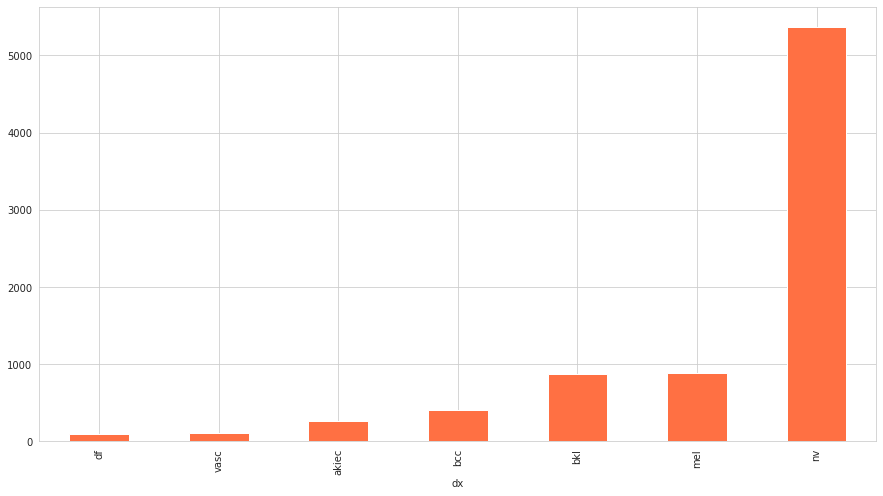

In [26]:
plt.figure(figsize=(15,8))
data_train.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar', color="#ff7043")

#### Validation set

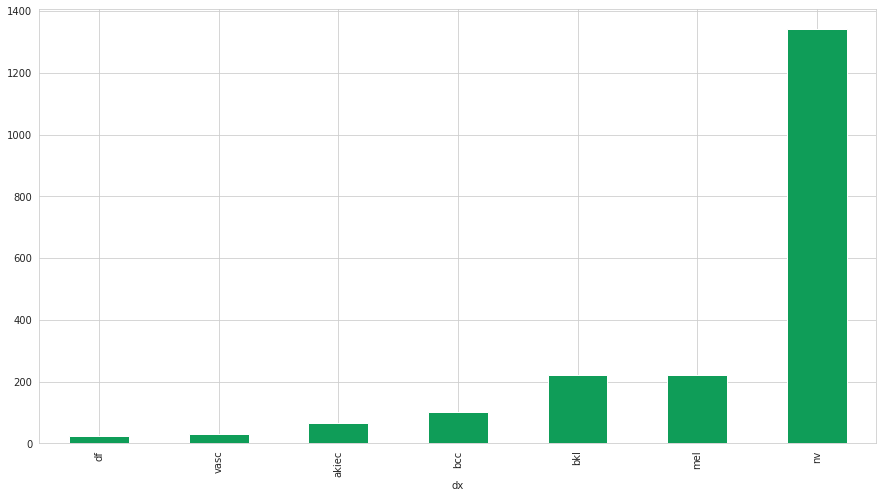

In [27]:
plt.figure(figsize=(15,8))
data_val.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar', color='#0f9d58')

### Data augmentation

In [19]:
# Load the dataset without any data augmentation, just to display samples from it
dataset_train_vanilla = HAM10000(DATA_FOLDER, train_ids, transforms=transforms.ToPILImage())

### Monitoring experiments

Tensorboard

#### Metrics

* Training/Validation Loss
* Training/Validation Accuracy
* Class specific metrics:
    * Precision
    * Recall
    * ROC AUC
    

In [20]:
sys.path.append("..")
from main import get_data_augmentation_transforms

/home/matteo/miniconda3/envs/lesions-classification/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matteo/miniconda3/envs/lesions-classification/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matteo/miniconda3/envs/lesions-classification/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

## Implementation details
[back to top](#Summary)

* A main python script to launch experiments
* A skeleton bash script to launch experiments
* The script prints the ETA of the experiment conclusion, which helps for scheduling experiments
* `at` used to schedule experiments, redirecting output/error to a `tmux` pane in order to monitor the execution

## Results
[back to top](#Summary)

In [21]:
from lib.utils import plot_tf_log

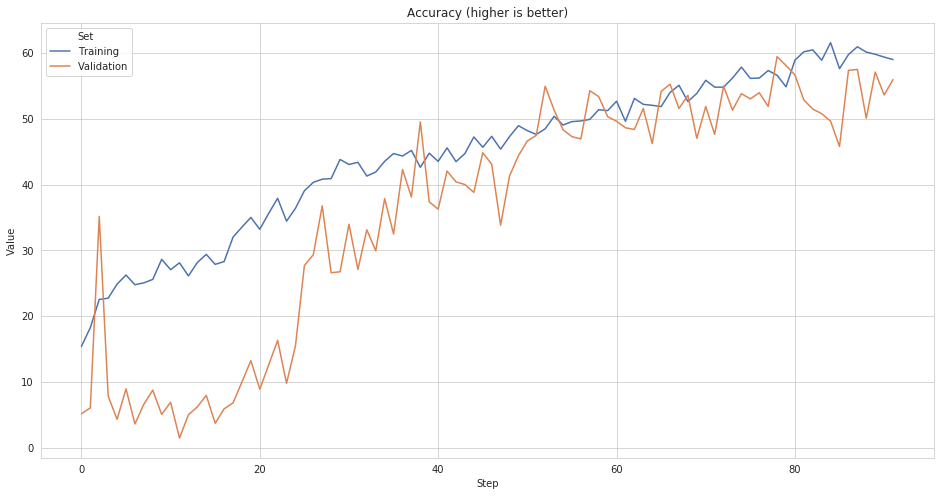

In [22]:
plt.figure(figsize=(16,8))
plot_tf_log(["../results/run6_train.csv", "../results/run6_val.csv"], "Accuracy (higher is better)")

Experiments have been performed on a PC with the following specs:

 * **CPU**: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
 * **RAM**: 32 GB
 * **OS**: Ubuntu 18.04
 * **GPU**: NVIDIA RTX 2080 TI GPU
 
Each "epoch" (considering both training and the forward pass on the whole validation set) took roughly 2:35.

## Conclusions
[back to top](#Summary)

### Future work

* Use additional data from other datasets
* Include additional information (age) however be sure not to fixate on that...
* Choose different values for the learning rate of layers deeper in the network (as opposed to those in the first layers)
* Visualize the early layers in the DS and see if there is any significant difference from the ones coming from the pretrained network on IMGNET
* use an even more sophisticated architecture Inception-V3/4
* Experiment with lighter networks and see if it is possible to have it run with decent performances on embedded machines/mobiles
* GradCAM technique to see what the network is focusing on
* Analyze mislabeled samples